In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(font_scale=1.3)

## First Classification Model
- Classify the different 'Product' categories

In [11]:
file = '../data/with_cleaned.csv'
df = pd.read_csv(file)

/home/yl238/Mudano/customer-complaints/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    150871
Debt collection                                                                  96750
Mortgage                                                                         57416
Credit card or prepaid card                                                      47091
Bank account or service                                                          31021
Student loan                                                                     23557
Consumer Loan                                                                    16413
Money transfer, virtual currency, or money service                                8136
Payday loan, title loan, or personal loan                                         7113
Other financial service                                                            292
Name: Product, dtype: int64

In [182]:
df = df[~(df['Product'] == 'Other financial service')].dropna(subset=['cleaned_text'])
df = df[df['cleaned_text'].str.len() >= 10]

In [183]:
model_df = df[['Product', 'Issue', 'Complaint ID', 'cleaned_text', 'Abbrev']]

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [185]:
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [186]:
X_train, X_test = train_df['cleaned_text'].values, val_df['cleaned_text'].values
y_train, y_test = train_df['Abbrev'].values, val_df['Abbrev'].values

In [198]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=1500, ngram_range=(1, 1))
tfidf_vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1500,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [199]:
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [200]:
X_train_tfidf.shape

(280301, 1500)

In [201]:
lr = LogisticRegression(C=1.0, max_iter=500, class_weight='balanced', multi_class='auto', solver='lbfgs', n_jobs=3)
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=3, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
tfidf_vect

## Debt collection idea:
- There's a large number of 'I don't knows' there, so what we can do is to build a model on the rest of the dataset, and then apply the model on the 'I don't knows'

In [202]:
targets = sorted(val_df['Abbrev'].unique())

In [203]:
pred = lr.predict(X_test_tfidf)
val_df['pred'] = pred

In [204]:
pred_proba = lr.predict_proba(X_test_tfidf)
proba_df = pd.DataFrame(pred_proba, columns=['pred_'+t for t in targets])
proba_df['max'] = proba_df.max(axis=1)
proba_df['Complaint ID'] = val_df['Complaint ID'].values

In [205]:
merged = pd.merge(val_df, proba_df, on='Complaint ID')

In [210]:
threshold = merged[merged['max']> 0.9]

In [211]:
print(classification_report(threshold['Abbrev'], threshold['pred']))

              precision    recall  f1-score   support

          BS       0.96      0.92      0.94      1883
          CC       0.91      0.96      0.94      2756
          CL       0.76      0.92      0.83       905
          CR       0.98      0.90      0.94     10275
          DC       0.93      0.89      0.91      4689
          MO       0.95      1.00      0.97      6074
          MT       0.86      0.96      0.91       705
          PL       0.68      0.91      0.78       264
          SL       0.89      0.99      0.94      2540

    accuracy                           0.94     30091
   macro avg       0.88      0.94      0.91     30091
weighted avg       0.94      0.94      0.94     30091



In [212]:
wrong_pl = threshold[(threshold['Abbrev']=='DC') & (threshold['pred'] != 'DC')]

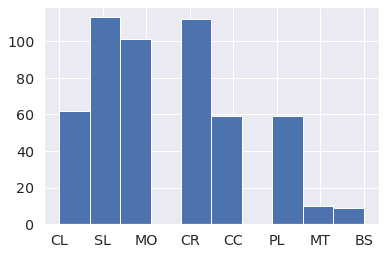

In [213]:
wrong_pl['pred'].hist()

In [215]:
for row in threshold[(threshold['Abbrev']=='DC') & (threshold['pred'] == 'CL')].iterrows():
    print('Narrative: ', df.loc[row[0],'Consumer complaint narrative'])
    print()
    print('Cleaned text: ', df.loc[row[0], 'cleaned_text'])
    print()
    print('Issue: ', df.loc[row[0], 'Issue'])
    print('Actual type: {}, Predicted type: {}'.format(row[1]['Abbrev'], row[1]['pred']))
    print()
    print()

Narrative:  They illegally spoke with my father about the account in XX/XX/2011. He called to get the payoff without my permission, and they gave him details. I was in the process of having the loan discharged for XXXX   XXXX due to XXXX from my father trying to XXXX  me. Instead of taking the check from my grandmother as a payoff ( again it was my information, they had no right to discuss it with him at all ) they applied the payoff in payments and accrued interest. Now they're harassing me and my XXXX yr old grandmother about paying the interest they illegally and unethically accrued. I continue to send in evidence of my XXXX, continue to try to discuss the privacy breach, continue to try to discuss the misappropriation of the payoff, and they continue to call me a liar and harass me.

Cleaned text:  illegally speak father account call payoff permission give detail process have loan discharge father try instead take check grandmother payoff information right discuss apply payoff paym